<a href="https://colab.research.google.com/github/harisuguru06/Automatic-Image-Captioning/blob/master/ImageCaptionLSTM_30K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM and Xception

In [1]:
#installing libararies
!pip install tensorflow
!pip install keras
!pip install pillow
!pip install numpy
!pip install tqdm
!pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=076accfefd7f188a0e8528bc50158be053e3441065fc33157c1a9338b0281458
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [ ]:
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
#!unzip Flickr8k_Dataset.zip -d /content/Flickr8k_Dataset

In [ ]:
#!unzip Flickr8k_text.zip -d /content/Flickr8k_text

In [ ]:
#remove mac files
#!rm -rf  /content/Flickr8k_Dataset/__MACOSX
#!rm -rf /content/Flickr8k_text/__MACOSX

Load 30K dataset

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harisuguru","key":"969272efc4d2b7eed0cd68b100d5c968"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr30k

100% 8.15G/8.16G [01:01<00:00, 148MB/s]
100% 8.16G/8.16G [01:01<00:00, 143MB/s]


In [10]:
!unzip -qq flickr30k.zip -d data

In [12]:
!rm -r /content/data/Images/flickr30k_images

In [36]:
#!rm  /content/data/Images/result.csv
!find  /content/data/Images/result.csv

find: ‘/content/data/Images/result.csv’: No such file or directory


In [83]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split(',' , 1)

        if img not in descriptions:
            descriptions[img] = [ caption ]
        else:
            descriptions[img].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [84]:
# Set these path according to project folder in you system

dataset_text = "/content/data/captions.txt"
dataset_images = "/content/data/Images"
#we prepare our text data
filename = dataset_text

#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 31784
Length of vocabulary =  19736


In [85]:
#extracting features
def extract_features(directory):
        print(directory)
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            if img == 'results.csv':
                print(img)
                continue
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features


In [86]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

/content/data/Images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/31783 [00:00<?, ?it/s]

In [ ]:
# copy to drive. to save time
#!cp /content/features.p  /gdrive/MyDrive/image-caption/modelbackup

# copy from drive
#!cp  /gdrive/MyDrive/image-caption/modelbackup/features.p /content/models/ 

In [ ]:
# copy model to drive
#!cp /content/models/model_9.h5 /gdrive/MyDrive/image-caption/modelbackup
#!cp /gdrive/MyDrive/image-caption/modelbackup/model_9.h5 /content/models/

In [87]:
features = load(open("features.p","rb"))

In [88]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    lst = file.split("\n")[:-1]
    photos = set()
    for line in lst[1:]:
        tup = line.split(",", 1)
        photos.add(tup[0])
    return list(photos)

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split("\t",1)
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        print(image,image_caption)
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions
    
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [ ]:
filename = dataset_text 
print(filename)
train_imgs = load_photos(filename)
print(train_imgs)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [90]:
print('training images size ',len(train_imgs))

training images size  31783


In [91]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

19736

In [92]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

72

In [93]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]
            
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((52, 2048), (52, 72), (52, 19736))

In [94]:
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras import metrics

# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.mae, metrics.categorical_accuracy])
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model30klstm_" + str(i) + ".h5")

Dataset:  31783
Descriptions: train= 31783
Photos: train= 31783
Vocabulary Size: 19736
Description Length:  72
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 72)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 72, 256)      5052416     ['input_7[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_6[0][0]']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


22601/31783 [====================>.........] - ETA: 23:13 - loss: 3.9265 - mean_absolute_error: 8.4493e-05 - categorical_accuracy: 0.2968

In [ ]:
# copy model to drive
#!cp /content/models/model_9.h5 /gdrive/MyDrive/image-caption/modelbackup




start man in red shirt is climbing up rock face end


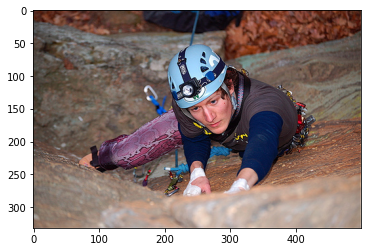

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
         return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text



path = '/content/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg'
img_path = path
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

**BLEU SCORE TEST**




start man in red shirt is standing on the street end


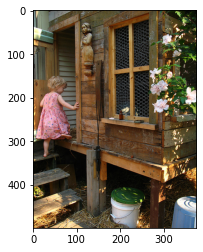

In [ ]:
path = '/content/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
img_path = path
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
hyp = str('man in red shirt is standing next to statue of funny face').split()

ref_a = str('A child in a pink dress be climb up a set of stair in an entry way').split()
ref_b = str('A girl go into a wooden building').split()
ref_c = str('A little girl climb into a wooden playhouse').split()
ref_d = str('A little girl climb the stair to her playhouse').split()
ref_e = str('A little girl in a pink dress go into a wooden cabin').split()


score = sentence_bleu([ref_a, ref_b, ref_c, ref_d, ref_e], hyp)
print(score)

# 1 - gram
score = sentence_bleu([ref_a, ref_b, ref_c, ref_d, ref_e], hyp, weights=(1,0,0,0))
print('1-gram', score)

# 1 - gram
score = sentence_bleu([ref_a, ref_b, ref_c, ref_d, ref_e], hyp, weights=(0.5,0.5,0,0))
print('2-gram', score)

score = sentence_bleu([ref_a, ref_b, ref_c, ref_d, ref_e], hyp, weights=(0.33,0.33,0.33,0))
print('3-gram', score)

score = sentence_bleu([ref_a, ref_b, ref_c, ref_d, ref_e], hyp, weights=(0.25,0.25,0.25,0.25))
print('4-gram', score)


1.2882297539194154e-231
1-gram 0.25
2-gram 7.458340731200295e-155
3-gram 5.6307666226860216e-204
4-gram 1.2882297539194154e-231


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg